# Projet Market Risk 2023

- Clément Muret
- Maxime Le Floch
- IF3

## Data import

In [40]:
file_path = r"C:\Users\clemm\OneDrive\Documents\Cours\S7\Market risk\Natixis stock.txt"

# Dictionary for storing prices by date
price_data = {}

with open(file_path, 'r') as file:
    lines = file.readlines()

for line in lines:
    date, price = line.strip().split('\t')  # Tab split
    # Conversions
    from datetime import datetime
    date = datetime.strptime(date, "%d/%m/%Y")
    price = float(price.replace(',', '.'))

    # Storing prices in the dictionary by date
    if date.year not in price_data:
        price_data[date.year] = {}
    if date.month not in price_data[date.year]:
        price_data[date.year][date.month] = []

    price_data[date.year][date.month].append(price)


# Retrieve prices from January 2015 to December 2016
Prix_2015_2016 = []
for year in range(2015, 2017):
    for month in range(1, 13):
        Prix_2015_2016 += price_data[year][month]

# Retrieve prices from January 2017 to December 2018
Prix_2017_2018 = []
for year in range(2017, 2019):
    for month in range(1, 13):
        Prix_2017_2018 += price_data[year][month]


## Useful functions

In [12]:
def calculate_returns(prices):
    returns = []
    for i in range(1, len(prices)):
        daily_return = (prices[i] - prices[i - 1]) / prices[i - 1]
        returns.append(daily_return)
    return returns

def calculate_mean(data):
    return sum(data) / len(data)

def calculate_std_dev(data):
    mean = calculate_mean(data)
    variance = sum((x - mean) ** 2 for x in data) / len(data)
    return variance ** 0.5

def calculate_quantile(data, p):
    sorted_data = sorted(data)
    index = int(p * len(sorted_data))
    return sorted_data[index]


### Question A (Ex2, part of Q1 and of Q2 of TD1) 

In [42]:
# This part is here to check that the results found with the kernel and EVT are consistent

# Return calculation  
returns_2015_2016 = calculate_returns(Prix_2015_2016)

confidence_level = [0.1, 0.05, 0.01]
print("Estimated VaR for 2015-2016 :")
print("Confiance\tVaR_loss\t\tVaR_gain")
for p in confidence_level:
    loss = calculate_quantile(returns_2015_2016, p)
    gain = calculate_quantile(returns_2015_2016, 1 - p)
    print(f"{(1-p)*100}%\t\t{loss}\t{gain}")

Estimated VaR for 2015-2016 :
Confiance	VaR_loss		VaR_gain
90.0%		-0.02780410742496053	0.02819865319865327
95.0%		-0.038933559035124875	0.03788316946211676
99.0%		-0.05704225352112663	0.055596196049743904


In [43]:
def biweight_kernel(u):
    if abs(u) <= 1:
        return (15 / 16) * (1 - u ** 2) ** 2
    else:
        return 0

def kernel_density_estimate(x, data, h):
    n = len(data)
    total = 0
    for xi in data:
        total += biweight_kernel((x - xi) / h)
    return total / (n * h)

# Estimate an integral by trapzes method
def trapezes(f, a, b, n, data, h):
    step = (b - a) / n
    sum = 0
    for i in range(1, n):
        xi = a + i * step
        xj = a + (i + 1) * step
        sum += f(xi, data, h) + f(xj, data, h)
    return sum * step / 2


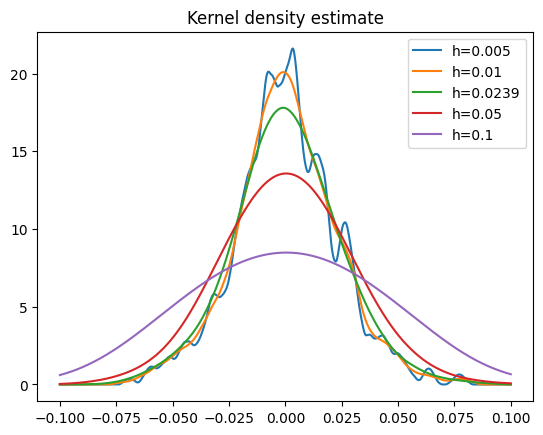

In [44]:
# Here we test several values of h to see which is the most suitable
import matplotlib.pyplot as plt
import numpy as np

sd = round(calculate_std_dev(returns_2015_2016), 4)

h = [0.005, 0.01, sd, 0.05, 0.1]
x = np.linspace(-0.1, 0.1, 1000)
for h_i in h:
    y = [kernel_density_estimate(xi, returns_2015_2016, h_i) for xi in x]
    plt.plot(x, y, label=f"h={h_i}")
plt.legend()
plt.title("Kernel density estimate")
plt.show()


In [45]:
def estimate_var(data, h, probability):
    # Estimation of the distribution function using the trapezoid method
    def cumulative_distribution(x, data, h):
        return trapezes(kernel_density_estimate, min(data), x, 1000, data, h)

    # Find the value where the distribution function reaches the probability level
    lower_bound = min(data)
    upper_bound = max(data)

    # Dichotomy method to find the value corresponding to the probability level
    while upper_bound - lower_bound > 1e-5:
        middle = (lower_bound + upper_bound) / 2
        if cumulative_distribution(middle, data, h) < probability:
            lower_bound = middle
        else:
            upper_bound = middle

    return upper_bound

confidence_level = [0.1, 0.05, 0.01]
h = 0.01 
print("Estimated VaR for 2015-2016 :") 
print("Confiance\tVaR")
for confidence in confidence_level:
    var_2015_2016_kernel = estimate_var(returns_2015_2016, h, confidence)
    print(f"{(1-confidence) * 100}%\t\t{var_2015_2016_kernel}")


Estimated VaR for 2015-2016 :
Confiance	VaR
90.0%		-0.027826494540893393
95.0%		-0.038123774394452845
99.0%		-0.05683570780710162


In [46]:
var_2015_2016_kernel = estimate_var(returns_2015_2016, h, 0.05)

# Calculating returns between 2017-2018 
returns_2017_2018 = calculate_returns(Prix_2017_2018)

# proportion of returns exceeding calculated VaR
rendements_sup_var = len([x for x in returns_2017_2018 if x <= var_2015_2016_kernel])
proportion = rendements_sup_var / len(returns_2017_2018)

# Display of the proportion of returns exceeding VaR
print(f"The proportion of returns exceeding VaR is : {proportion*100}%")
print(f"There are {rendements_sup_var} on {len(returns_2017_2018)}")


The proportion of returns exceeding VaR is : 1.5717092337917484%
There are 8 on 509


### Question B (Ex2, Q5 of TD2) 

In [47]:
# Identify returns less than VaR during 2015-2016
losses = [x for x in returns_2015_2016 if x <= var_2015_2016_kernel]

# Calculate Expected Shortfall (ES = average loss above VaR)
expected_shortfall = sum(losses) / len(losses) 

print(f"The Expected Shortfall for VaR is : {expected_shortfall}")


The Expected Shortfall for VaR is : -0.05336181815045533


### Question C (Ex2, Q1 and Q2 of TD3)

In [48]:
# retrieves all available prices
Prix = []
for year in range(2015, 2019):
    for month in range(1, 13):
        Prix += price_data[year][month]

# Calculation of corresponding returns
returns = calculate_returns(Prix)

sorted_returns = sorted(returns)


def k(n):
    return np.log(n)

def Pickands_estim(data):
    n = len(data)
    etam = data[n-int(k(n))]-data[n-2*int(k(n))]
    den = data[n-2*int(k(n))]-data[n-4*int(k(n))]
    res = np.log(etam/den)
    return res/np.log(2)


# invert everything to be able to calculate the Pikands index on losses
sorted_returns_losses = [-x for x in sorted_returns]
sorted_returns_losses = sorted_returns_losses[::-1]

# Calculating the Pikands index
pikands_gain = Pickands_estim(sorted_returns)
pikands_losses = Pickands_estim(sorted_returns_losses)

print("Pikands Index :")
print("Losses\t\t\tGain")
print(f"{-pikands_losses}\t{pikands_gain}")


Pikands Index :
Losses			Gain
0.5089715779341741	0.5772338569463286


In [49]:

def VaR_EVT(p, data, pickands):
    n = len(data)
    num = ((k(n)/(n*(1-p)))**pickands - 1) * (data[n-int(k(n))]-data[n-2*int(k(n))])
    den = 1 - 2**(-pickands)
    return num/den + data[n-int(k(n))]

alpha = [0.1, 0.05, 0.01]
print("VaR EVT :")
print("Confiance\tVaR loss\t\tVaR gain")
for p in alpha:
    loss = VaR_EVT(1-p, sorted_returns_losses, pikands_losses)
    gain = VaR_EVT(1-p, sorted_returns, pikands_gain)
    print(f"{(1-p)*100}%\t\t{-loss}\t{gain}")


VaR EVT :
Confiance	VaR loss		VaR gain
90.0%		-0.018676315001953256	0.034136255033759964
95.0%		-0.03459467977312686	0.03787128303972365
99.0%		-0.05563667261604414	0.05522424941671052


### Question D (Ex2, Q3 and Q4 of TD4)

In [35]:
import numpy as np
import math
import pandas as pd
import numpy.random as rd
from scipy.stats import linregress
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

data=pd.read_excel("Dataset TD4.xlsx")
nouveaux_noms = {
    'transaction date (1=1day=24 hours)': 'transaction_date',
    'bid-ask spread': 'bid-ask_spread',
    'volume of the transaction (if known)': 'volume',
    'Sign of the transaction': 'sign',
    'Price (before transaction)': 'price'
}

data = data.rename(columns=nouveaux_noms) #We rename the columns to use them more easily
volume = []
price = []
sign = []
for i in range(len(data) - 1):
    if pd.notna(data['volume'].iloc[i]):
        volume.append(data['volume'].iloc[i])
        price.extend([data['price'].iloc[i], data['price'].iloc[i + 1]]) #We retrieve the price at which the transaction was carried out and the price at t+1 to see the impact of the order on the market.
        sign.append(data['sign'].iloc[i])



Annualized volatility: 0.05849549575608429

Estimation of eta: 2.280706114725874e-08
Mean Squared Error: 0.00023873091719548648 ; R^2: 0.9607480862831544

Estimation of gamma: 0.00050237805904092
Mean Squared Error: 0.0004907505222142958 ; R^2: 0.9193112589657632


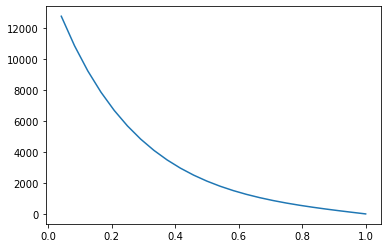

In [39]:
# Calculate returns to obtain volatility
returns = [(data['price'].iloc[i + 1] / data['price'].iloc[i]) - 1 for i in range(len(price) - 1)]

# Check if volatility is consistent (assuming hourly volatility)
sigma_24hour = calculate_std_dev(returns) * np.sqrt(24) #We multiply the std by str(24) because we got the volatility on one hour
sigma_total=sigma_24hour*np.sqrt(252) #We multiply the std by str(252) because we got the volatility on one day
print(f"Annualized volatility: {sigma_total}")

# Calculate volume*signed to have the volume of the buying or selling order
signed_volume = np.array([sign[i]*volume[i] for i in range(len(volume))])

# Calculate price differences in steps of 2, we are using 2steps because the first price is before the transaction and the second one is after so we need this to have the impact of the order
price_diff = np.array([price[i + 1] - price[i] for i in range(0, len(price) - 1, 2)])

# Calculate squared of the volume*signed
signed_volume_squared = np.array([sign[i] * volume[i] * volume[i] for i in range(len(price_diff))])

# Define variables for the regression to find gamma and eta
gamma_prices = price_diff
eta_prices = -price_diff
X_gamma = signed_volume.reshape(-1, 1)
X_eta = np.column_stack((signed_volume, signed_volume_squared))

# Create a linear regression model
model = LinearRegression()

# Regression for eta
model.fit(X_eta, eta_prices)

tau=1/24 #Tau is the number that represent at the step (we can do one transaction each hour)

eta = model.coef_[1] * tau  # eta/tau is the coefficient for squared volumes, so multiply by tau to get eta

# Predictions and evaluation for eta
y_pred_eta = model.predict(X_eta)
mse_eta = mean_squared_error(eta_prices, y_pred_eta)
r2_eta = r2_score(eta_prices, y_pred_eta)

print(f"\nEstimation of eta: {eta}")
print(f"Mean Squared Error: {mse_eta} ; R^2: {r2_eta}")

# Regression for gamma
model.fit(X_gamma, gamma_prices)
gamma = model.coef_[0]  # Gamma is the slope of the regression line

# Predictions and evaluation for gamma
y_pred_gamma = model.predict(X_gamma)
mse_gamma = mean_squared_error(gamma_prices, y_pred_gamma)
r2_gamma = r2_score(gamma_prices, y_pred_gamma)

print(f"\nEstimation of gamma: {gamma}")
print(f"Mean Squared Error: {mse_gamma} ; R^2: {r2_gamma}")

# Liquidation strategy
X_to_liquidate=15000 #It's an example
possible_transaction=[(1/24)*i for i in range(1,25)] #One transaction possible each hour
Lambda_value = 10**(-4.0) #It's an example of the aversion (taste of risk)
K_value = np.sqrt(Lambda_value * (sigma_total**2) / eta)
liquidation_quantity=[]
for t_value in possible_transaction :
    liquidation_quantity.append(np.sinh(K_value * (1 - t_value)) * X_to_liquidate / np.sinh(K_value * 1))

# Plot the liquidation strategy
plt.plot(possible_transaction, liquidation_quantity)
plt.show()


### Question E (Q4 of TD5)

In [42]:
#Importation and transformation fo the data 
data=pd.read_excel("Dataset TD5.xlsx")
data_GBP=data.iloc[2:, :3]
data_SEK=data.iloc[2:, 4:7]
data_CAD=data.iloc[2:, 8:11]

#We need to have the half of the bid-ask spread on each FX rates to get the returns of each one.
half_bidask_GBP=[(data_GBP.iloc[i,1]+data_GBP.iloc[i,2])/2 for i in range(0,len(data_GBP)-1)]
half_bidask_SEK=[(data_SEK.iloc[i,1]+data_SEK.iloc[i,2])/2 for i in range(0,len(data_SEK)-1)]
half_bidask_CAD=[(data_CAD.iloc[i,1]+data_CAD.iloc[i,2])/2 for i in range(0,len(data_CAD)-1)]

#Returns of each FX rates
returns_gbp=[(half_bidask_GBP[i+1]/half_bidask_GBP[i])-1 for i in range(0,len(data_GBP)-2)]
returns_sek=[(half_bidask_SEK[i+1]/half_bidask_SEK[i])-1 for i in range(0,len(data_GBP)-2)]
returns_cad=[(half_bidask_CAD[i+1]/half_bidask_CAD[i])-1 for i in range(0,len(data_GBP)-2)]

In [19]:
#We tried to do the correlation matrix by using the wavelets but we didn't get a good result, this is the part on the wavelets:
def calculate_empirical_moment(data, k, N):
    result = 0
    for i in range(1, len(data)*N):
        result += np.abs(data[int(i/N)] - data[int((i-1)/N)])**k
    return result * (1/N * len(data))

def calculate_empirical_moment_halved_resolution(data, k, N):
    result = 0
    for i in range(1, int((len(data)*N)/2)):
        result += np.abs(data[int(2*i/N)] - data[int(2*(i-1)/N)])**k
    return result * (2/N * len(data))

#We didn't get any good result from this so we did the correlation matrix with excel and the result is : 
correlation_matrix = np.array([[1, 0.191420071, 0.244926851],
                               [0.191420071, 1, 0.192442093],
                               [0.244926851, 0.192442093, 1]]) 

In [45]:
#This is the part on the Hursr exhibitor 

#Method to have the moment of the data for each k and N each one > 0 
def calculate_empirical_moment(data, k, N):
    result = 0
    for i in range(1, len(data)*N):
        result += np.abs(data[int(i/N)] - data[int((i-1)/N)])**k
    return result * (1/N * len(data))

#Method to have the moment halved resolution for k = 2 and any N > 0 
def calculate_empirical_moment_halved_resolution(data, k, N):
    result = 0
    for i in range(1, int((len(data)*N)/2)):
        result += np.abs(data[int(2*i/N)] - data[int(2*(i-1)/N)])**k
    return result * (2/N * len(data))

#Method to estimate the Hurst exhibitor
def estimate_Hurst(data, k, N):
    M2 = calculate_empirical_moment(data, k, N)
    M2_halved = calculate_empirical_moment_halved_resolution(data, k, N)
    return 0.5 * math.log2(M2_halved/M2)

#Method to get the scale volatily by using the Hurst exhibitor
def scale_volatility(std, hurst_exponent):
    return std * (2 ** hurst_exponent)

hurst_gbp= estimate_Hurst(returns_gbp, 2, 10)
hurst_sek=estimate_Hurst(returns_sek, 2, 10)
hurst_cad=estimate_Hurst(returns_cad, 2, 10)
print(hurst_gbp)
print(hurst_sek)
print(hurst_cad)
scale_vol=[]
scale_vol.append(scale_volatility(calculate_std_dev(returns_gbp),hurst_gbp))
scale_vol.append(scale_volatility(calculate_std_dev(returns_sek),hurst_sek))
scale_vol.append(scale_volatility(calculate_std_dev(returns_cad),hurst_cad))
for i in scale_vol:
    print(i)

#Method to get the mutiplication between the correlation_matrix obtained with Excel and the matrix of the scale volatility
def calculate_covariance_matrix(correlation_matrix, volatility_vector):
    correlation_matrix = np.array(correlation_matrix)
    Sigma = np.diag(volatility_vector)
    covariance_matrix = np.dot(Sigma, np.dot(correlation_matrix, Sigma))
    return covariance_matrix
covariance_matrix = calculate_covariance_matrix(correlation_matrix, scale_vol)
print("Covariance Matrix:")
print(covariance_matrix)

0.5
0.5
0.5
0.0008814409953038501
0.00046263269044024267
0.0007159859130200779
Covariance Matrix:
[[7.76938228e-07 7.80579310e-08 1.54573173e-07]
 [7.80579310e-08 2.14029006e-07 6.37442282e-08]
 [1.54573173e-07 6.37442282e-08 5.12635828e-07]]


In [24]:
#To calculate the volatility directly from the series of price we decided to try to create different datasets for different time scales
#Create windows (5)
column_names = ['Date', 'High', 'Low']

data_GBP.columns = column_names
data_SEK.columns = column_names
data_CAD.columns = column_names

data_GBP['Date'] = pd.to_datetime(data_GBP['Date'])
data_SEK['Date'] = pd.to_datetime(data_SEK['Date'])
data_CAD['Date'] = pd.to_datetime(data_CAD['Date'])

data_GBP.index = pd.to_datetime(data_GBP.index)
data_SEK.index = pd.to_datetime(data_SEK.index)
data_CAD.index = pd.to_datetime(data_CAD.index)

date_ranges = [
    ('2016-03-07 09:00:00', '2016-03-07 10:00:00'),
    ('2016-03-07 09:00:00', '2016-03-07 19:00:00'),
    ('2016-03-07 09:00:00', '2016-03-08 09:00:00'),
    ('2016-03-07 09:00:00', '2016-03-10 09:00:00'),
    ('2016-03-07 09:00:00', '2016-03-14 09:00:00'),
    ('2016-03-07 09:00:00', '2016-04-07 09:00:00'),
    ('2016-03-07 09:00:00', '2016-06-07 09:00:00')
]
#After create this samples, we didn't succeed to create the dataset with the final date that are each values on the right


In [29]:
#We decided to just apply the two method (overlapping and non-overlapping) on the whole dataset

#With overlapping
std_GBP = calculate_std_dev(returns_gbp)
std_SEK = calculate_std_dev(returns_sek)
std_CAD = calculate_std_dev(returns_sek)
print("Result with Overlapping : \n")
print(f"- Standard deviation of GBP : {std_GBP}")
print(f"- Standard deviation of GBP annualised: {std_GBP*np.sqrt(12)}") #Annualized (we have 6 months so for annualised it's the root of 12)
print(f"- Standard deviation of SEK: {std_SEK}")
print(f"- Standard deviation of SEK annualised: {std_SEK*np.sqrt(12)}") #Annualised
print(f"- Standard deviation of CAD: {std_CAD}")
print(f"- Standard deviation of CAD annualised: {std_CAD*np.sqrt(12)}") #Annualised
print()

#Without overlapping
returns_gbp_without_overlapping=[(half_bidask_GBP[i+1]/half_bidask_GBP[0])-1 for i in range(0,len(data_GBP)-2)]
returns_sek_without_overlapping=[(half_bidask_SEK[i+1]/half_bidask_SEK[0])-1 for i in range(0,len(data_GBP)-2)]
returns_cad_without_overlapping=[(half_bidask_CAD[i+1]/half_bidask_CAD[0])-1 for i in range(0,len(data_GBP)-2)]
std_GBP_without_overlapping = calculate_std_dev(returns_gbp_without_overlapping)
std_SEK_without_overlapping = calculate_std_dev(returns_sek_without_overlapping)
std_CAD_without_overlapping = calculate_std_dev(returns_cad_without_overlapping)
print("Result with Non-Overlapping : \n")
print(f"- Standard deviation of GBP : {std_GBP_without_overlapping}")
print(f"- Standard deviation of GBP annualised: {std_GBP_without_overlapping*np.sqrt(12)}") #Annualised
print(f"- Standard deviation of SEK : {std_SEK_without_overlapping}")
print(f"- Standard deviation of SEK annualised: {std_SEK_without_overlapping*np.sqrt(12)}") #Annualised
print(f"- Standard deviation of CAD : {std_CAD_without_overlapping}")
print(f"- Standard deviation of CAD annualised: {std_CAD_without_overlapping*np.sqrt(12)}") #Annualised

Result with Overlapping : 

- Standard deviation of GBP : 0.0006232729049951721
- Standard deviation of GBP annualised: 0.002159080676865376
- Standard deviation of SEK: 0.00032713071260887243
- Standard deviation of SEK annualised: 0.0011332140299095596
- Standard deviation of CAD: 0.00032713071260887243
- Standard deviation of CAD annualised: 0.0011332140299095596


Result with Non-Overlapping : 

- Standard deviation of GBP : 0.03799434923003744
- Standard deviation of GBP annualised: 0.13161628653388058
- Standard deviation of SEK : 0.012694382028994778
- Standard deviation of SEK annualised: 0.04397462928981649
- Standard deviation of CAD : 0.010946213754529869
- Standard deviation of CAD annualised: 0.037918796746710025
